In [1]:
import imp
import os

import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import pyfmi

from BuildingControlSimulator.BuildingModels.IDFPreprocessor import IDFPreprocessor
from BuildingControlSimulator.ControlModels.Deadband import Deadband

plotly.offline.init_notebook_mode(connected=True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
steps_per_hour = 60.
step_size = 3600. / steps_per_hour

In [4]:
idf = IDFPreprocessor(
    idf_name=f"Zone5VAV-Pri-SecLoop_{os.environ['ENERGYPLUS_INSTALL_VERSION']}.idf",
    weather_name="USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw",
    timesteps=steps_per_hour,
    init_temperature=20.
)
idf.preprocess()
idf.make_fmu()

IDFPreprocessor loading .idf file: /root/home/lib/building-control-simulator/idf/v8-9-0/Zone5VAV-Pri-SecLoop_8-9-0.idf


'/root/home/lib/building-control-simulator/fmu/v8-9-0/Zone5VAV_Pri_SecLoop_8_9_0_prep.fmu'

In [5]:
bm = pyfmi.load_fmu(fmu=idf.fmu_path)
# config
output_fpath = os.path.join(os.environ["PACKAGE_DIR"], "data/output_simulation_loop.csv")
output_plot_fname = "co_simulation_output_{}.png".format(idf.fmu_name.replace(".fmu", ""))

# config times (always in seconds unless specified)
# model must be initialized for multiples of 24 hours (1 day)
# this is the full durtation of the simulation, not step size
start_time = 60.0*60*(24*202)
init_final_time = 60.0*60*(24*210)
final_time = 60.0*60*(24*203)
print("Model init starting ...")
bm.initialize(start_time, init_final_time)
print("Complete.")
t_step = start_time

Model init starting ...
Complete.


In [6]:
controller = Deadband.from_idf(building_model=bm, idf=idf)
controller.stp_heat = 21.
controller.stp_cool = 25.
controller.deadband = 2.

In [7]:
simulator_output_keys = ["time_seconds", "step_status"]
row_keys = simulator_output_keys + controller.output_keys() + list(bm.get_model_variables().keys())

In [8]:
t_ctrl_idx = row_keys.index("FMU_SPACE1_1_Zone_Air_Temperature")

In [9]:
print("_"*80)
print("Entering co-simulation loop")
print("_"*80)

rows = []
t_ctrl = idf.init_temperature
HVAC_mode = 1
while t_step <= final_time:
    # do step
    c_var_list = controller.do_step(t_ctrl)
    step_status = (bm.do_step(current_t=t_step, step_size=step_size, new_step=True))
    # save data as row
    row = [t_step, step_status] + c_var_list + [bm.get(k)[0] for k in bm.get_model_variables().keys()]
    rows.append(row)
    # TODO add multizone support
    t_ctrl = row[t_ctrl_idx]
    # step time forward
    t_step += step_size


# freeing the instance before script end seems to cause a segmentation fault
# model.free_instance()
# model.terminate()

print("="*80)
print("Simulation finished.")
print("="*80)

________________________________________________________________________________
Entering co-simulation loop
________________________________________________________________________________
Simulation finished.


In [10]:
df = pd.DataFrame.from_records(rows, columns=row_keys)

In [14]:
df

,time_seconds,step_status,HVAC_mode,stp_heat,stp_cool,deadband,FMU_T_heating_stp,FMU_T_cooling_stp,FMU_T_control_type,FMU_Environment_Site_Outdoor_Air_Relative_Humidity,...,FMU_SPACE4_1_Zone_Air_System_Sensible_Cooling_Rate,FMU_SPACE4_1_Zone_Total_Internal_Total_Heating_Rate,FMU_SPACE5_1_Zone_Air_Temperature,FMU_SPACE5_1_Zone_Thermostat_Heating_Setpoint_Temperature,FMU_SPACE5_1_Zone_Thermostat_Cooling_Setpoint_Temperature,FMU_SPACE5_1_Zone_Air_System_Sensible_Heating_Rate,FMU_SPACE5_1_Zone_Air_System_Sensible_Cooling_Rate,FMU_SPACE5_1_Zone_Total_Internal_Total_Heating_Rate,total_heat,total_internal_heat
0,17452800.0,0,0,21.0,25.0,2.0,0.0,0.0,0.0,90.116667,...,0.0,3.62,23.670411,20.0,0.0,0.29,0.0,5.1,4.65,28.44
1,17452860.0,0,0,21.0,25.0,2.0,0.0,0.0,0.0,90.233333,...,0.0,3.62,23.666725,20.0,0.0,0.29,0.0,5.1,4.65,28.44
2,17452920.0,0,0,21.0,25.0,2.0,0.0,0.0,0.0,90.350000,...,0.0,3.62,23.663044,20.0,0.0,0.29,0.0,5.1,4.65,28.44
3,17452980.0,0,0,21.0,25.0,2.0,0.0,0.0,0.0,90.466667,...,0.0,3.62,23.659368,20.0,0.0,0.29,0.0,5.1,4.65,28.44
4,17453040.0,0,0,21.0,25.0,2.0,0.0,0.0,0.0,90.583333,...,0.0,3.62,23.655697,20.0,0.0,0.29,0.0,5.1,4.65,28.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,17538960.0,0,2,21.0,25.0,2.0,0.0,0.0,0.0,89.550000,...,0.0,3.62,23.685204,20.0,-60.0,0.29,0.0,5.1,4.65,28.44
1437,17539020.0,0,2,21.0,25.0,2.0,0.0,0.0,0.0,89.700000,...,0.0,3.62,23.681498,20.0,-60.0,0.29,0.0,5.1,4.65,28.44
1438,17539080.0,0,2,21.0,25.0,2.0,0.0,0.0,0.0,89.850000,...,0.0,3.62,23.677797,20.0,-60.0,0.29,0.0,5.1,4.65,28.44
1439,17539140.0,0,2,21.0,25.0,2.0,0.0,0.0,0.0,90.000000,...,0.0,3.62,23.674102,20.0,-60.0,0.29,0.0,5.1,4.65,28.44


In [11]:
df["total_heat"] = (df["FMU_SPACE5_1_Zone_Air_System_Sensible_Heating_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE3_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE2_1_Zone_Air_System_Sensible_Heating_Rate"]
                    + df["FMU_SPACE1_1_Zone_Air_System_Sensible_Heating_Rate"])

In [12]:
df["total_internal_heat"] = (df["FMU_SPACE5_1_Zone_Total_Internal_Total_Heating_Rate"] 
                    + df["FMU_SPACE4_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE3_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE2_1_Zone_Total_Internal_Total_Heating_Rate"]
                    + df["FMU_SPACE1_1_Zone_Total_Internal_Total_Heating_Rate"])

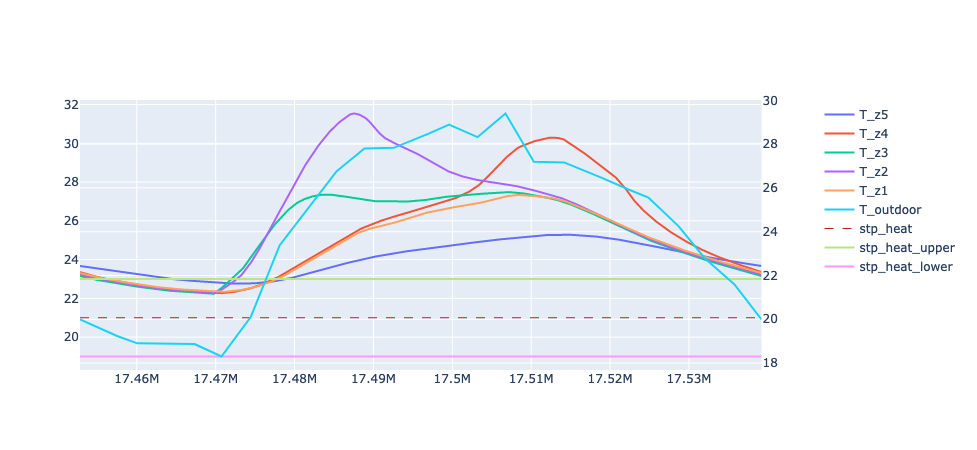

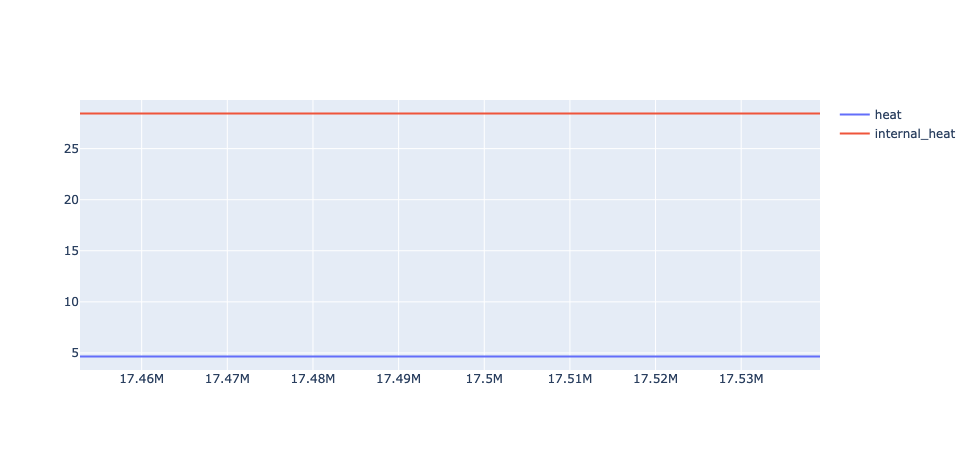

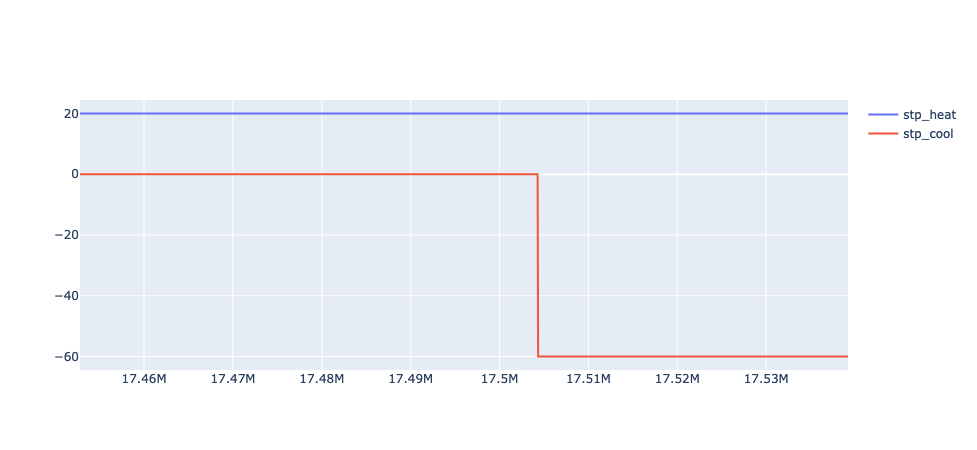

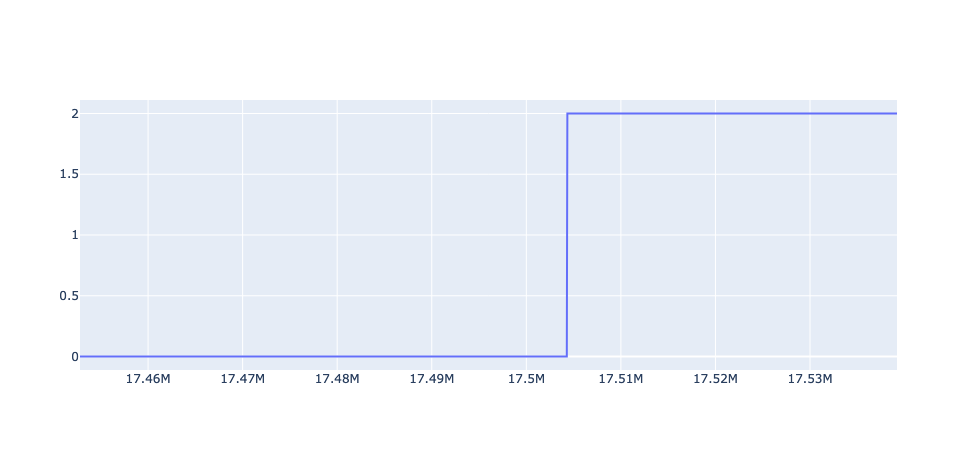

In [13]:
fig = plotly.subplots.make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE5_1_Zone_Air_Temperature"], mode='lines',name='T_z5'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE4_1_Zone_Air_Temperature"], mode='lines',name='T_z4'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE3_1_Zone_Air_Temperature"], mode='lines',name='T_z3'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE2_1_Zone_Air_Temperature"], mode='lines',name='T_z2'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Air_Temperature"], mode='lines',name='T_z1'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(
    x=df.time_seconds, y=df["FMU_Environment_Site_Outdoor_Air_Drybulb_Temperature"], mode='lines',name='T_outdoor')
              , row=1, col=1, secondary_y=True)

fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"],
                         mode='lines',
                         line=dict(color='firebrick', width=1,dash='dash'),
                         name='stp_heat'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"] + df["deadband"], mode='lines',name='stp_heat_upper'), row=1, col=1, secondary_y=False)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["stp_heat"] - df["deadband"], mode='lines',name='stp_heat_lower'), row=1, col=1, secondary_y=False)
fig.show()

fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_heat"], mode='lines',name='heat'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["total_internal_heat"], mode='lines',name='internal_heat'), row=1, col=1)
fig.show()
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Thermostat_Heating_Setpoint_Temperature"], mode='lines',name='stp_heat'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["FMU_SPACE1_1_Zone_Thermostat_Cooling_Setpoint_Temperature"], mode='lines',name='stp_cool'), row=1, col=1)
fig.show()
fig = plotly.subplots.make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=df.time_seconds, y=df["HVAC_mode"], mode='lines',name='HVAC_mode'), row=1, col=1)
fig.show()
# fig.update_layout(height=800, width=1000, title_text="Simulation results")

# TODO
fix the duplicated ThermostatSetpoint:SingleHeating in prep
add output var for ThermostatSetpoint:SingleHeating

In [13]:
opts = model.simulate_options()
opts['ncp'] = int((final_time) / (60. * 5))

opts['ncp']

864

In [14]:
res = model.simulate(final_time=final_time, options=opts)

Simulation interval    : 0.0 - 259200.0 seconds.
Elapsed simulation time: 0.5764751660001366 seconds.


In [ ]:
res.data_matrix.shape

In [ ]:
col_keys = model_keys.copy()
col_keys.insert(0, "time")

In [ ]:
for i in range(res.data_matrix.shape[0]):
    print(f"{i}: {res.data_matrix[i].any(0)}: {col_keys[i]}")

In [ ]:
res.data_matrix[9]

In [ ]:
res.data_matrix[11]